<a href="https://colab.research.google.com/github/Ms-Noxolo/Team_EN3_Jozi/blob/master/Noxolo_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Movies Recommendations

In [ ]:
# importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import random
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler

!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import NormalPredictor
from surprise import SVDpp, evaluate
from surprise import NMF

In [ ]:
# loading in the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
links = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')
imdb = pd.read_csv('imdb_data.csv')
scores = pd.read_csv('genome_scores.csv')
Sample_Submission = pd.read_csv('sample_submission.csv')

### Datasets Overview

Below we take a general review and summary of the datasets taking note of the shapes, info and features i.e. columns all of which will help us establish a good approach into performing the exploratory data analyses of the datasets.

In [ ]:
# The movies dataframe
print(movies.head())
print(movies.shape)

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
(62423, 3)


In [ ]:
# The links dataframe
print(links.head())
print(links.shape)

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
(62423, 3)


Given the similar shape of the movie and links i.e. movie homepage dataframes, we can already note that the two dataframes can be merged to form a metadataset using the Ids of the movies.

In [ ]:
# The ratings dataframe
print(ratings.head())
print(ratings.shape)

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
(100004, 4)


It is not surpring that this dataframe has alomst 2x more entries than the movie dataset because an individual user can watch more than one movies and also provide ratings for a selection of various movies.

In [ ]:
# The imdb dataframe
print(imdb.head())
print(imdb.shape)

   movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|

This dataframe consists of additional movie metadata scraped from IMDB using the links.csv file. These include cast/crew, budgets, plots as well as the runtime. The IMDB platform has its own movie-listing requirements therefore this could be the reason why the dataframe doesn't capture all the movies in the links.csv

In [ ]:
# The ratings dataframe
print(tags.head())
print(tags.shape)

   userId  movieId               tag   timestamp
0       3      260           classic  1439472355
1       3      260            sci-fi  1439472256
2       4     1732       dark comedy  1573943598
3       4     1732    great dialogue  1573943604
4       4     7569  so bad it's good  1573943455
(1093360, 4)


In [ ]:
# The score dataframe
print(scores.head())
print(scores.shape)

   movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075
(15584448, 3)


In [ ]:
# Overview of the training dataframe
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


We will see if the presence of the timestamp feature is off importance in building a suitable recommender systems.

In [ ]:
# Overview of the testing dataframe
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


This is the dataset that will be used in testing the algorithms build for constructing recommender systems.

### Data Preprocessing

Data preprocessing is the process of detecting and correcting corrupt or inaccurate records from the dataset and identifying incomplete, incorrect, inaccurate or irrelevant parts of the data.

In [ ]:
# Storing the years from the titles separately:

# We specify the parantheses so we don’t conflict with movies that have years in their titles
movies["year"] = movies.title.str.extract("(\(\d\d\d\d\))",expand=False)
# Removing the parentheses
movies["year"] = movies.year.str.extract("(\d\d\d\d)",expand=False)
# Removing the years from the ‘title’ column
movies["title"] = movies.title.str.replace("(\(\d\d\d\d\))", "")
# Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies["title"] = movies["title"].apply(lambda x: x.strip())

In [ ]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [ ]:
# combining the dataframe with all movie information
data = pd.merge(movies, imdb, how ='left', on ='movieId')
metadata = pd.merge(data, links, how ='left', on='movieId')
metadata.head()

,movieId,title,genres,year,title_cast,director,runtime,budget,plot_keywords,imdbId,tmdbId
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,114709,862.0
1,2,Jumanji,Adventure|Children|Fantasy,1995,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,113497,8844.0
2,3,Grumpier Old Men,Comedy|Romance,1995,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,113228,15602.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,114885,31357.0
4,5,Father of the Bride Part II,Comedy,1995,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,113041,11862.0


In [ ]:
print(metadata.shape)

(62423, 11)


In [ ]:
#Replace NaN with an empty string
metadata = metadata.fillna('')

# Removing the "$": budget
cost = []
for key, value in metadata["budget"].iteritems():
    a = value.replace("," , "")
    cost.append(a)
metadata['budget'] = cost

# Replacing the "|" with a white space: cast
cast = []
for key, value in metadata["title_cast"].iteritems():
    a = value.replace("|" , ",")
    cast.append(a)
metadata['title_cast'] = cast

# Replacing the "|" with a white space: plot_keywords
plot = []
for key, value in metadata["plot_keywords"].iteritems():
    b = value.replace("|" , ",")
    plot.append(b)
metadata['plot_keywords'] = plot


# Replacing the "|" with a white space: genres
genre = []
for key, value in metadata["genres"].iteritems():
    c = value.replace("|" , ",")
    genre.append(c)
metadata['genres'] = genre

In [ ]:
# Looking at the new dataframe
metadata.head()

,movieId,title,genres,year,title_cast,director,runtime,budget,plot_keywords,imdbId,tmdbId
0,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81,$30000000,"toy,rivalry,cowboy,cgi animation",114709,862
1,2,Jumanji,"Adventure,Children,Fantasy",1995,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...",Jonathan Hensleigh,104,$65000000,"board game,adventurer,fight,game",113497,8844
2,3,Grumpier Old Men,"Comedy,Romance",1995,"Walter Matthau,Jack Lemmon,Sophia Loren,Ann-Ma...",Mark Steven Johnson,101,$25000000,"boat,lake,neighbor,rivalry",113228,15602
3,4,Waiting to Exhale,"Comedy,Drama,Romance",1995,"Whitney Houston,Angela Bassett,Loretta Devine,...",Terry McMillan,124,$16000000,"black american,husband wife relationship,betra...",114885,31357
4,5,Father of the Bride Part II,Comedy,1995,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Albert Hackett,106,$30000000,"fatherhood,doberman,dog,mansion",113041,11862


### Exploratory Data Analysis

We need to perform investigative and detective analysis on our data to see if we can unearth any useful insights. We have data being generated from websites so it’s important to utilize Exploratory Data Analysis to analyze all this text data, with the aid of Visuals to help organizations make data-driven decisions.

In [ ]:
# Importing neccesary libraries
import matplotlib.pyplot as plt 
import json
import seaborn as sns
%matplotlib inline
import re
from wordcloud import WordCloud

### The number of movies that are being released
Knowing the numbers around movies can help paint a picture of the relationship that exists between movies and 'users' as availability of movies can be play a huge role in the general growth of the movie-audience industry.

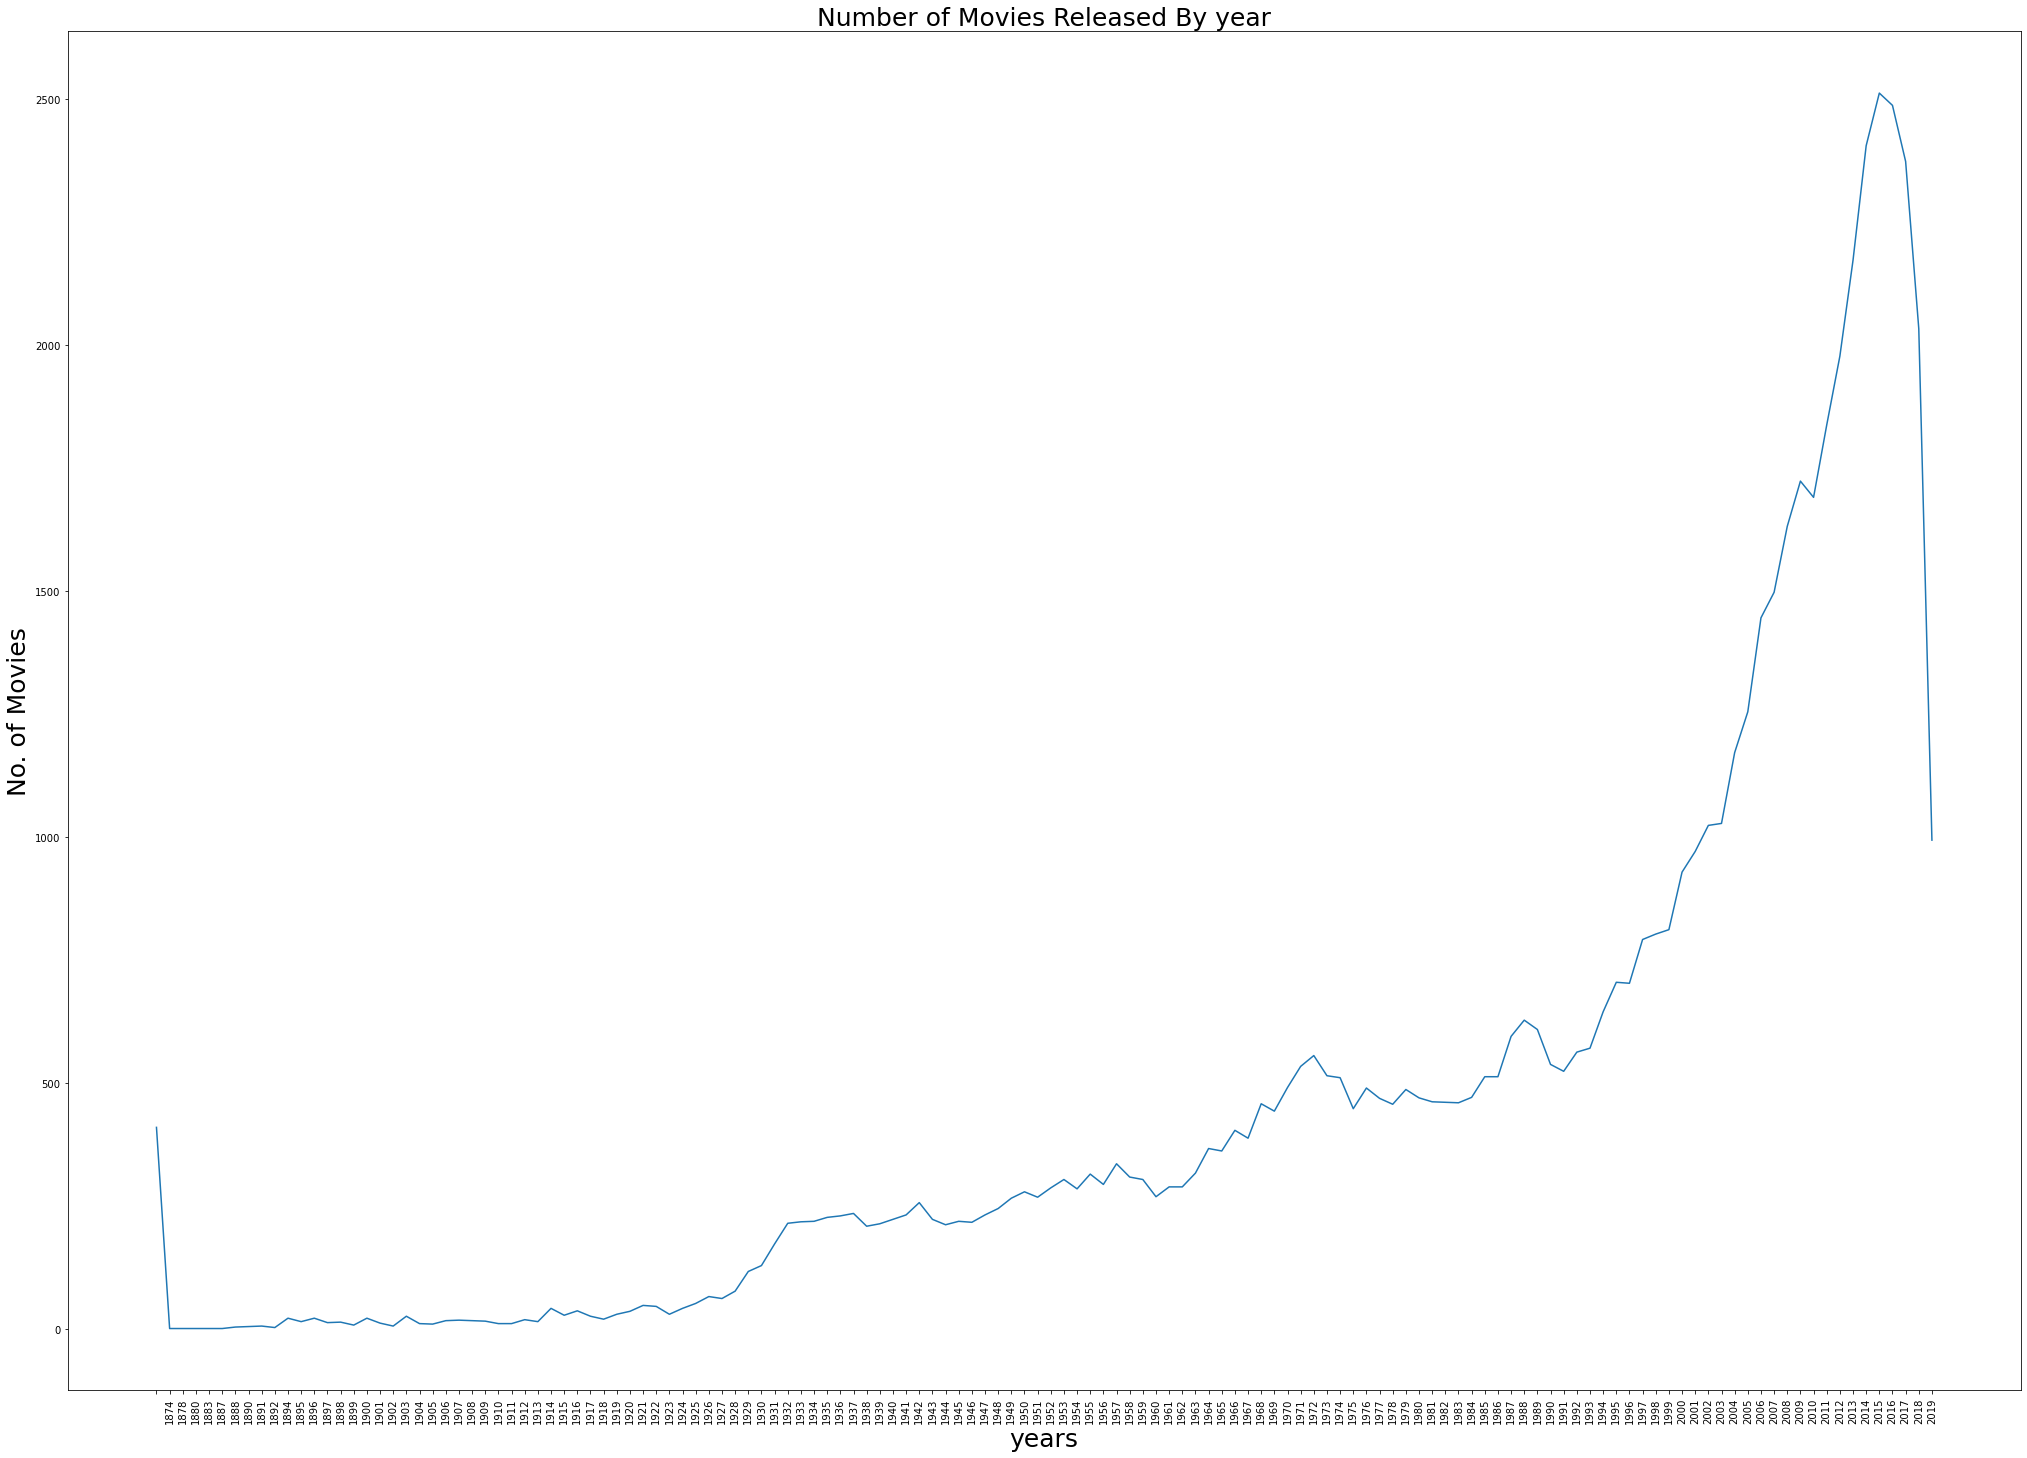

In [ ]:
# The number of Movies released per year
num = metadata.groupby('year').count()
plt.figure(figsize=(35,25))
plt.plot(num.index, num['budget'])
plt.xlabel("years", size=25)
plt.xticks(rotation='vertical')
plt.ylabel('No. of Movies', size=25)
plt.title('Number of Movies Released By year', size=25)
plt.show()

Although there has been some drops in the number of movies released throughout the years, it is clear to see that there generally has been a significant growth in movies being released with the growth being exponential around 1990s.

### The years with majority of movies being released
Now we want to find out which years are dominating the movie industry.

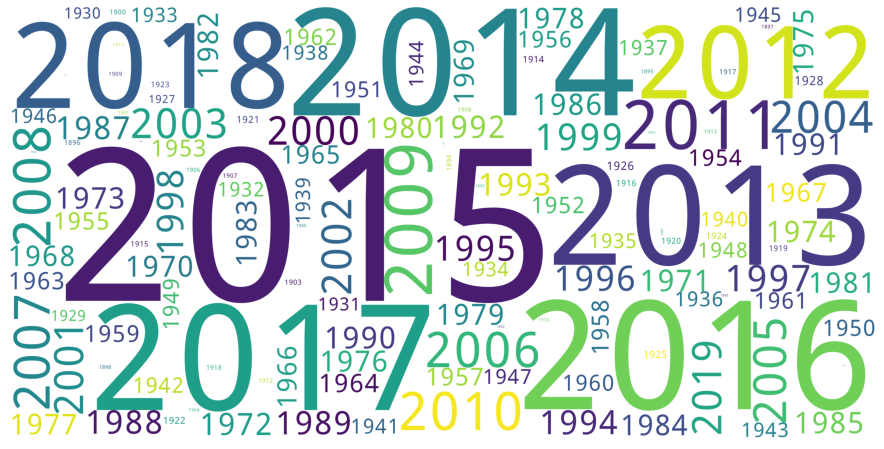

In [ ]:
# Looking at the all the years of movies releases
year_corpus = metadata['year'].value_counts()
# Generating the wordcolud
year_wordcloud = WordCloud(background_color='white', height=2000, width=4000).generate_from_frequencies(year_corpus)
plt.figure(figsize=(16,8))
plt.imshow(year_wordcloud)
plt.axis('off')
plt.show()

We can see that the wordcloud is correspodning with the plot above that the movie industry grew exponentially in the 2000s, with 2015 and 2016 being the most frequent yeas of movie releases. 

### The kind of movies that are being released
Now we want to find out which movies, in terms of genre are dominating the movie industry.

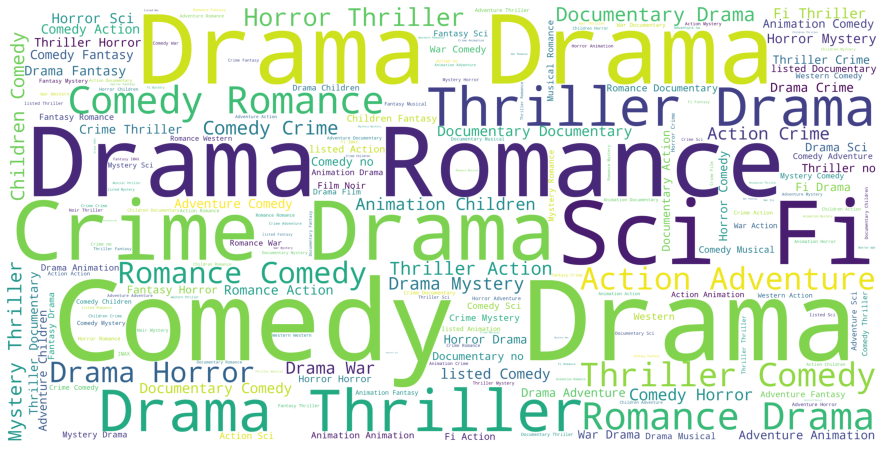

In [ ]:
# Looking at the titles and checking for any similarity
metadata['genres'] = metadata['genres'].astype('str')
genre_corpus = ' '.join(metadata['genres'])
#Generating the stopwords
stopword = ['no genres', 'no', 'genres', 'genre', 'listed']
# Generating the wordcolud
genre_wordcloud = WordCloud(stopwords=stopword, background_color='white', height=2000, width=4000).generate(genre_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

We can see that majority of the movies in the dataset are Comedy, Drama and Romance.

In [ ]:
# Looking at the titles and checking for any similarity
metadata['title'] = metadata['title'].astype('str')
title_corpus = ' '.join(metadata['title'])
# Generating the wordcolud
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

As the worldcloud suggests, there are a lot of movies that pertain tell the stories of a boy and/or girl, movies about wars, crime, America and sequels as indicated by "II". These correspond to the genres unpacked above.


The dataset consists of 27248 movies for which we have data on overview, cast/crew and budget. This is close to only 44% of the entire dataset. Although this is less than 505 of the entire dataset, it is more than enough to perform very useful analysis and discover interesting insights about the world of movies.

In [ ]:
# Looking at the plots and checking for any similarity
metadata['plot_keywords'] = metadata['plot_keywords'].astype('str')
overview_corpus = ' '.join(metadata['plot_keywords'])
# Generating the wordcolud
plot_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.show()

### The runtime of movies that are being released
Movies have progressed in terms of runtime, From the 1 minute slient, black & white clips to epic 3 hour gci. So, in this section, let us try and gain some additional insights about the nature of movie lengths and their evolution over time.

Now we want to find out the duration of these movies being released are.

In [ ]:
# converting the column to numeric
metadata['runtime'] = pd.to_numeric(metadata['runtime'])

# Viewing relative durations of the movies
metadata['runtime'].describe()

count    13521.000000
mean       101.366615
std         29.867424
min          1.000000
25%         90.000000
50%         98.000000
75%        110.000000
max        877.000000
Name: runtime, dtype: float64

This is only a subset of the dataset i.e. 22%, and from this wee can see that the average length of a movie is about 1 hour and 40 minutes. The longest movie recorded in this dataset is 877 minutes (or 14 hours) long.

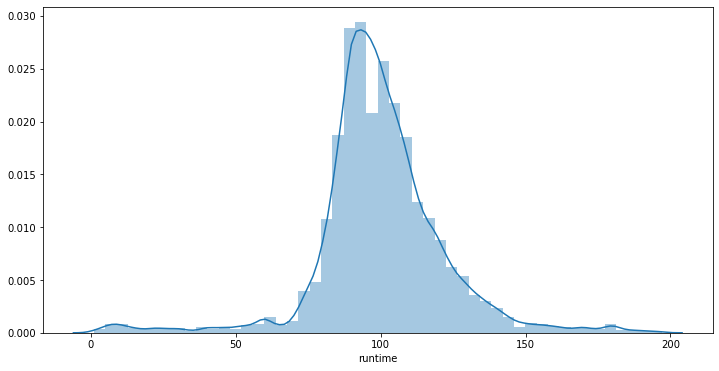

In [ ]:
# The distribution of these mainstream movies .i.e movies less than 3 hours (or 200 minutes) long. 
plt.figure(figsize=(12,6))
sns.distplot(metadata[(metadata['runtime'] < 200) & (metadata['runtime'] > 0)]['runtime'])

Possible trends in what may be considered as the appropriate length of a movie across the years.

In [ ]:
# Looking at the shortest Movies
metadata[metadata['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime').head(10)

,runtime,title,year
27660,1.0,Dickson Greeting,1891
15650,1.0,Four Heads Are Better Than One (Un homme de tête),1898
15655,1.0,"Pyramid of Triboulet, The (La pyramide de Trib...",1899
26438,1.0,Stille Nacht I: Dramolet,1988
23396,1.0,The Kiss,1900
26402,1.0,Santa Claus,1898
24182,2.0,Fresh Guacamole,2012
26384,2.0,Curb Dance,2010
23374,2.0,The Menacing Eye,1960
26466,3.0,Beastie Boys: Sabotage,1994


Majority of the short movies were filmed in the late 1890s and the beginning of the 20th century and they're absurdly only a minute long. The exceptn in the Top 10 are *Fresh Guacamole* released in 2012 and *Curb Dance* released in 2010 both being two minutes long.

In [ ]:
# Looking at the longest Movies
metadata[metadata['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime', ascending=False).head(10)

,runtime,title,year
25235,877.0,Taken,2002
17899,750.0,Law of the Lawless (Brigada),2002
18527,644.0,Sam Peckinpah: Man of Iron,1993
19611,629.0,Death on the Staircase (Soupçons),2004
19762,600.0,New York: A Documentary Film,1999
9084,561.0,"Kingdom II, The (Riget II)",1997
7342,561.0,"Kingdom, The (Riget)",1994
12749,552.0,Into the West,2005
19771,551.0,Tie Xi Qu: West of the Tracks (Tiexi qu),2003
20745,540.0,Island at War,2004


Notably, almost all the entries in the above list were released in the 2000s and are actually miniseries and sequels and as such, can't count as feature length films. There isn't much insight we can gther from this as there is no way of distinguishing feature length films from TV Mini Series from our dataset unless done manually, and this could take days.

### The Credits and Keywords 
Based Recommender
The quality of a recommender would be increased with the usage of better metadata and by capturing more of the finer details. Therefore in this section we will explore the 3 top actors, the directors, related genres, and the movie plot keywords.

## Content-Based Recommender
Building a system that recommends movies that are similar to a particular movie by computing pairwise cosine similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score threshold.

#COLLABORATIVE FILTERING
A technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching for a group of people with similar taste to this specific users. It is a method used to predict a rating for a user item pair based on the history of ratings given by the user and given to the item.

In [ ]:
reader = Reader()
train = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

###SVD

The Singular Value Decomposition (SVD), a method from linear algebra that has been generally used as a dimensionality reduction technique in machine learning. SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K < N)



In [ ]:
svd = SVD()
cross_validate(svd, train, measures=['RMSE', 'MAE'])

Now we train our dataset and arrive at a prediction 

In [ ]:
data_train = train.build_full_trainset()
svd.fit(data_train)

Breakdown of what is put into the model:


* a = userId
* b = movieId
* c = rating
* d = expected rating












In [ ]:
a = 
b =
c =

In [ ]:
d = svd.predict(a, b, c)
print (d)

For our prediction, we give the model a different users info (userId, movieId and their rating). It will then predict an estimate of what our user may rate this movie.

Comparing other recommendation algorithms

In [ ]:
norm = NormalPredictor()
cross_validate(norm, train, measures=['RMSE', 'MAE'])
data_train = train.build_full_trainset()
norm.fit(data_train)
d = norm.predict(a, b, c)
print ('Normal predictor': d)

svd2 = SVDpp()
cross_validate(svd2, train, measures=['RMSE', 'MAE'])
data_train = train.build_full_trainset()
svd2.fit(data_train)
d = svd2.predict(a, b, c)
print ('SVD++': d)

nmf = NMF()
cross_validate(nmf, train, measures=['RMSE', 'MAE'])
data_train = train.build_full_trainset()
nmf.fit(data_train)
d = nmf.predict(a, b, c)
print ('Non-negative Matrix Factorization': d)

# References
1. Beginner Tutorial: Recommender Systems in Python
https://www.datacamp.com/community/tutorials/recommender-systems-python

2. Build a Recommendation Engine With Collaborative Filtering
https://realpython.com/build-recommendation-engine-collaborative-filtering/

3. How to Build Simple Recommender Systems in Python
https://medium.com/swlh/how-to-build-simple-recommender-systems-in-python-647e5bcd78bd

4. Introduction to Recommendation System. Part 1
https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75

5. Building a Recommender System With Pandas
https://medium.com/towards-artificial-intelligence/building-a-recommender-system-with-pandas-1ca0bb03fdce